In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# from PIL import Image
import librosa

import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader, Dataset

import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, v2
from torchmetrics.classification import MultilabelAccuracy
from torchmetrics import ConfusionMatrix, Accuracy, Precision, Recall, MeanMetric

%config InlineBackend.figure_format='retina'

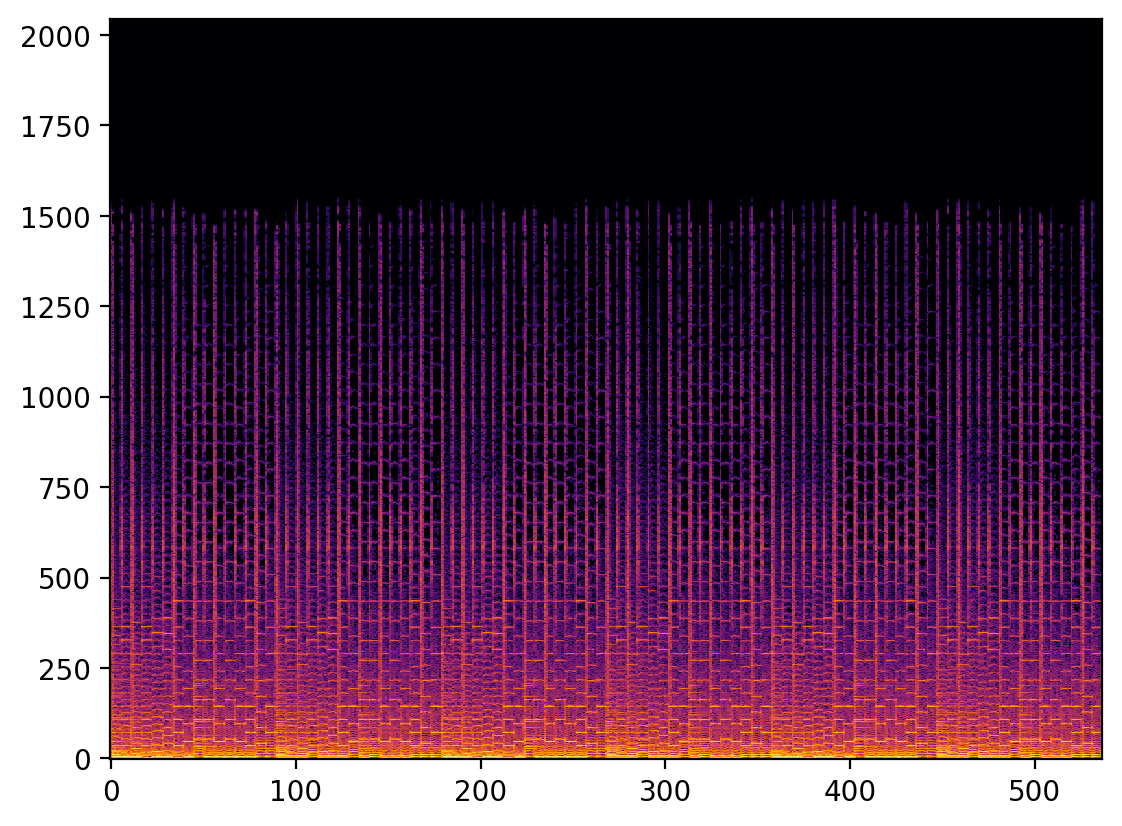

In [5]:
mixture_np = np.load("/Users/hal/Documents/Programming Projects/python_projects/SongCreator/splitTrackData/track0002/mixture.npy")

# Convert to tensor
mixture_t = torch.tensor(mixture_np)

_, ax = plt.subplots(1, 1)
ax.imshow(mixture_t, origin="lower", aspect="auto", interpolation="nearest", cmap="inferno")

In [6]:
instruments = ["piano", "bass", "drums", "guitar", "synth"]

full_dataset = SpectrogramSeparationDataset(
    root_dir='splitTrackData/',
    instruments=instruments,
    transform=transforms.Compose([
        transforms.RandomCrop((1984, 352)),
        # transforms.Resize((416, 160)),
        # transforms.ToTensor(),
    ])
)

# Define split ratios (e.g., 70% train, 15% val, 15% test)
train_ratio = 0.85
val_ratio = 0.15
test_ratio = 0.0

# Compute lengths
total_size = len(full_dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

# Perform random split
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size],
                                                        generator=torch.Generator().manual_seed(42))  # fixed seed for reproducibility


In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=3, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=3, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=3, shuffle=True)

In [8]:
num_classes = len(instruments)

In [9]:
import segmentation_models_pytorch as smp

num_instruments = 5
model = smp.Unet(
    encoder_name="resnet18",        # choose encoder, e.g. resnet18
    encoder_weights="imagenet",       # use ImageNet pre-trained weights
    in_channels=1,                    # input channels (e.g., spectrogram RGB or 1 for grayscale)
    classes=num_instruments,          # output channels = number of instrument masks
    activation=None,                  # use sigmoid later, or leave None if using BCEWithLogitsLoss
)

In [10]:
model = model.to(device)

optimiser = torch.optim.AdamW(params=model.parameters(), lr=1e-3)
criteria = nn.BCEWithLogitsLoss()

train_loss = MeanMetric().to(device)
epochs = 10

In [11]:
import torch.nn.functional as F

def train_one_epoch():
    losses = MeanMetric().to(device)
    model.train()
    
    for mixture, instruments_gt in train_dataloader:
        mixture = mixture.to(device)
        instruments_gt = instruments_gt.to(device)
        
        optimiser.zero_grad()
        
        # Forward pass: output predicted masks with shape [B, num_instruments, H, W]
        masks_pred = model(mixture)
        
        masks_pred = masks_pred.unsqueeze(2)
        mixture_expanded = mixture.unsqueeze(1)
        
        # Apply predicted masks to the mixture to get instrument spectrogram predictions.
        preds = masks_pred * mixture_expanded
        
        # Compute the loss
        loss = F.l1_loss(preds, instruments_gt)
        loss.backward()
        optimiser.step()
        
        losses.update(loss, mixture.size(0))
    
    return losses.compute().item()


def validation_one_epoch():
    losses = MeanMetric().to(device)
    model.eval()
    
    with torch.no_grad():
        for mixture, instruments_gt in val_dataloader:
            mixture = mixture.to(device)
            instruments_gt = instruments_gt.to(device)
            
            masks_pred = model(mixture)
            masks_pred = masks_pred.unsqueeze(2)  # add channel dim: [B, num_instruments, 1, H, W]
            mixture_expanded = mixture.unsqueeze(1)  # [B, 1, 3, H, W]
            preds = masks_pred * mixture_expanded
            
            loss = F.l1_loss(preds, instruments_gt)
            losses.update(loss, mixture.size(0))
    
    return losses.compute().item()

In [12]:
print("Baseline validation loss:", validation_one_epoch())
for epoch in range(epochs):
    train_loss = train_one_epoch()
    val_loss = validation_one_epoch()
    
    print("Epoch:", epoch + 1,
          "| Train Loss:", round(train_loss, 2),
          "| Validation Loss:", round(val_loss, 2))

Baseline validation loss: 41.46772003173828
Epoch: 1 | Train Loss: 18.57 | Validation Loss: 20.07


KeyboardInterrupt: 

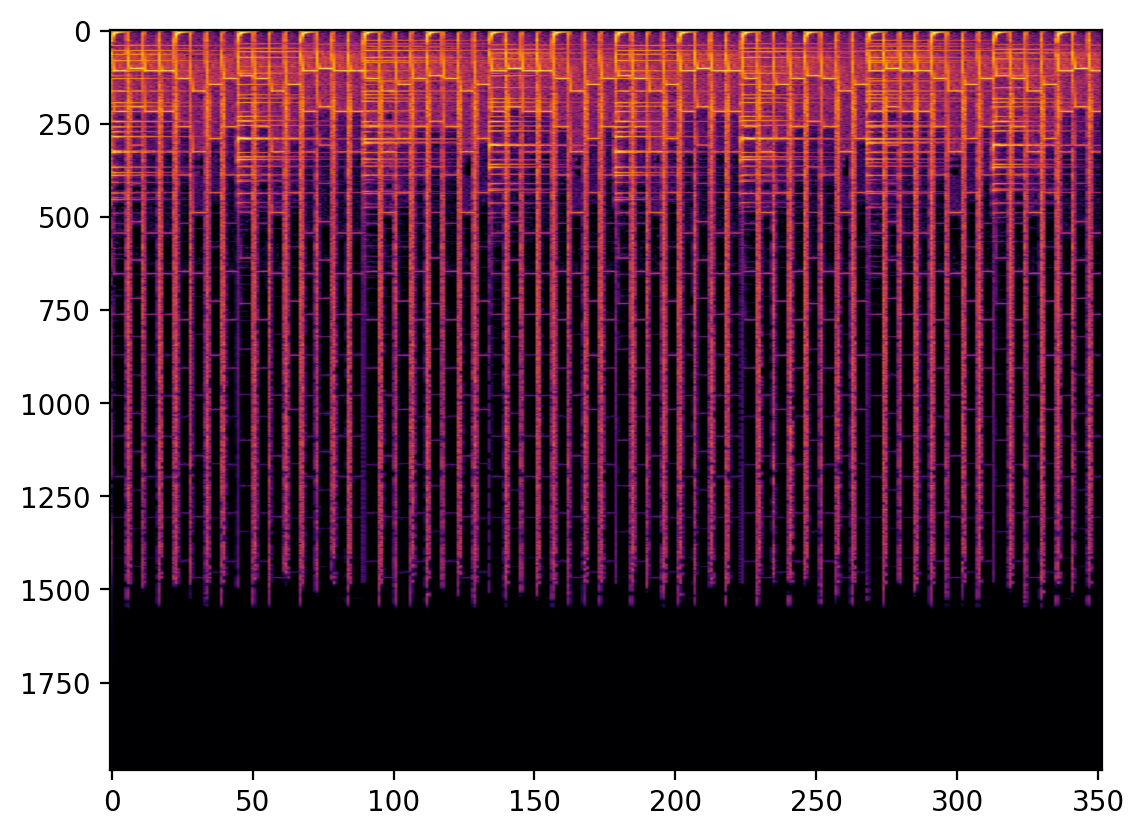

In [ ]:
model.eval()
with torch.no_grad():
    # Get one batch; you might use next(iter(val_dataloader))
    batch = next(iter(train_dataloader))
    mixture, instruments_gt = batch
mixture_sample = mixture[0].cpu().numpy()
plt.imshow(mixture_sample[0], aspect="auto", cmap="inferno")

torch.Size([3, 5, 1984, 352])


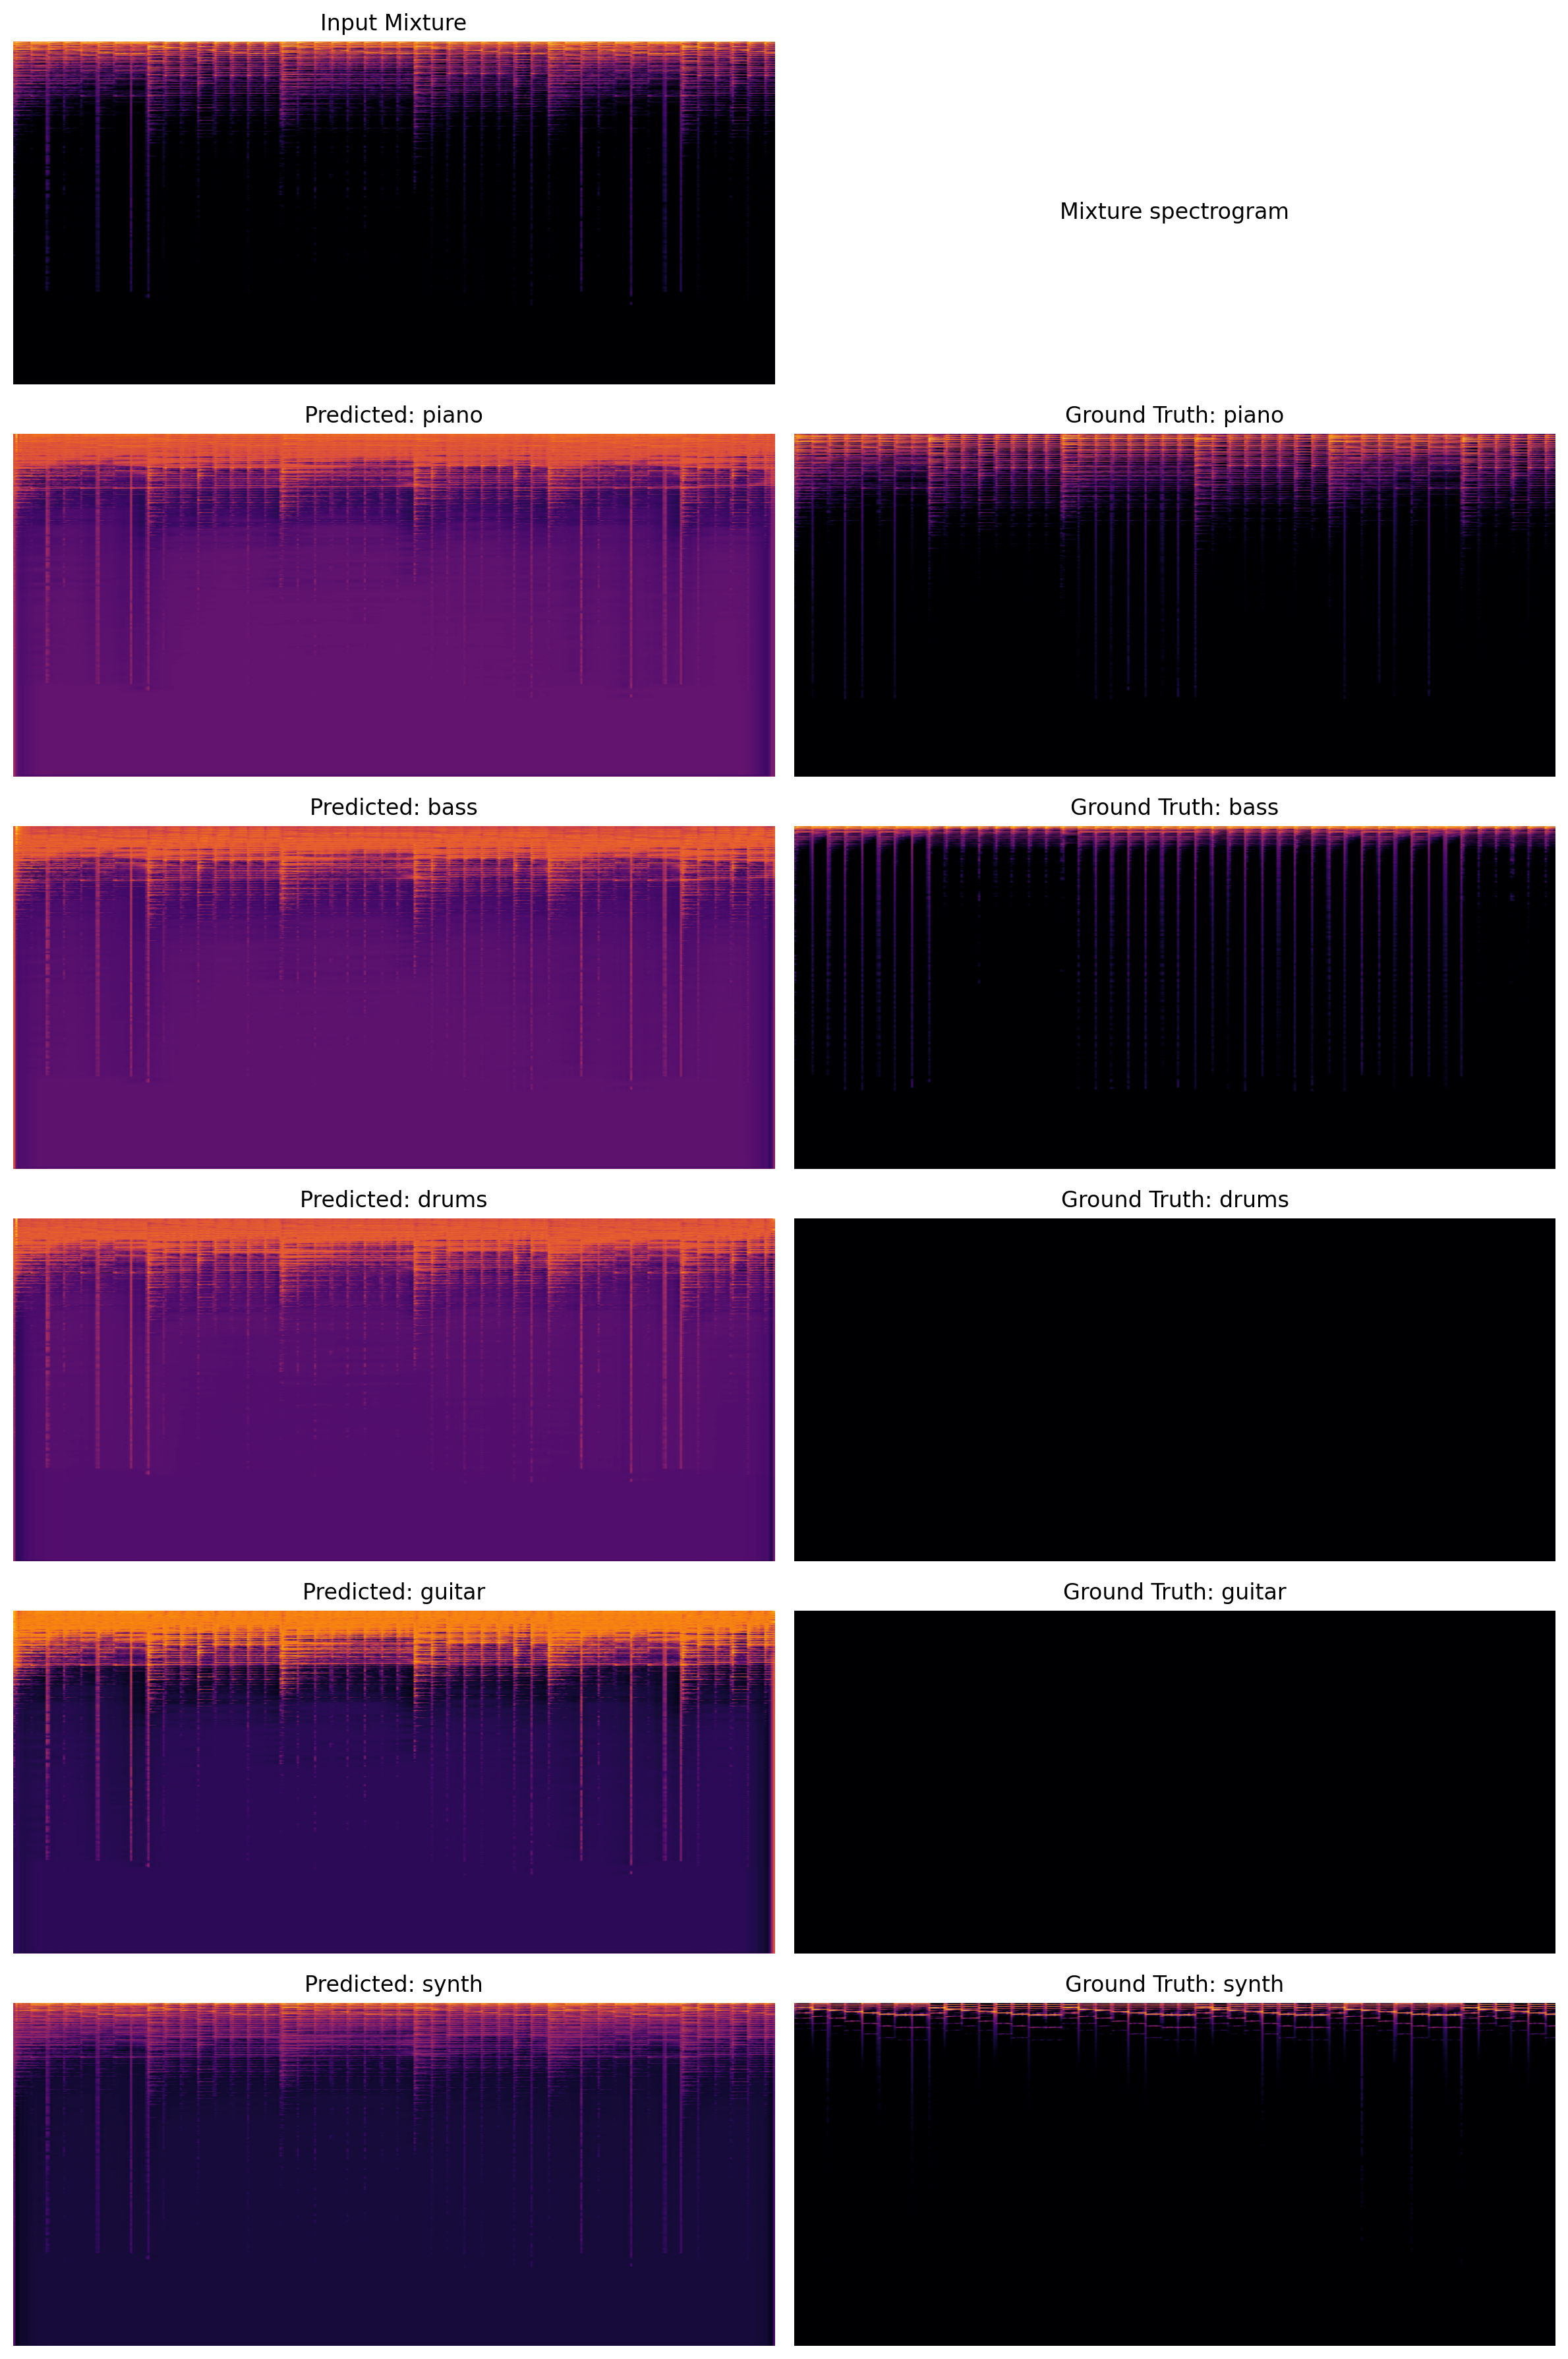

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Let's grab one batch from your validation dataloader
model.eval()
with torch.no_grad():
    # Get one batch; you might use next(iter(val_dataloader))
    batch = next(iter(train_dataloader))
    mixture, instruments_gt = batch  # mixture: [B, 3, H, W], instruments_gt: [B, num_instruments, 3, H, W]
    mixture = mixture.to(device)
    instruments_gt = instruments_gt.to(device)
    
    # Forward pass to get predicted masks
    masks_pred = model(mixture)  # expected shape: [B, num_instruments, H, W]
    print(masks_pred.shape)
    
    # Add channel dimension so masks can be applied across the 3 channels
    masks_pred = masks_pred.unsqueeze(2)  # now: [B, num_instruments, 1, H, W]
    mixture_expanded = mixture.unsqueeze(1)  # now: [B, 1, 3, H, W]
    
    # Multiply to obtain predicted instrument spectrograms
    preds = masks_pred * mixture_expanded  # [B, num_instruments, 3, H, W]

# Choose the first sample from the batch for visualization
sample_idx = 0
mixture_sample = mixture[sample_idx].cpu().numpy()            # [3, H, W]
preds_sample = preds[sample_idx].cpu().numpy()                  # [num_instruments, 3, H, W]
gt_sample = instruments_gt[sample_idx].cpu().numpy()            # [num_instruments, 3, H, W]

# Transpose to (H, W, 3) for matplotlib display
mixture_img = mixture_sample[0]

# If you have instrument names (make sure this list matches your ordering):
instrument_names = instruments
num_instruments = preds_sample.shape[0]

# Plot the mixture, predictions, and ground-truth for each instrument
fig, axes = plt.subplots(num_instruments + 1, 2, figsize=(12, 3 * (num_instruments + 1)))

# Top row: display the mixture
axes[0, 0].imshow(mixture_img, aspect="auto", cmap="inferno")
axes[0, 0].set_title("Input Mixture")
axes[0, 0].axis("off")
axes[0, 1].axis("off")
axes[0, 1].text(0.5, 0.5, "Mixture spectrogram", ha='center', va='center', fontsize=12)

# For each instrument, show the predicted and ground-truth spectrograms
for i in range(num_instruments):
    # Transpose predicted and ground truth spectrograms to [H, W, 3]
    pred_img = np.transpose(preds_sample[i], (1, 2, 0))
    gt_img = np.transpose(gt_sample[i], (1, 2, 0))
    
    axes[i+1, 0].imshow(pred_img, aspect="auto", cmap="inferno")
    axes[i+1, 0].set_title(f"Predicted: {instrument_names[i]}")
    axes[i+1, 0].axis("off")
    
    axes[i+1, 1].imshow(gt_img, aspect="auto", cmap="inferno")
    axes[i+1, 1].set_title(f"Ground Truth: {instrument_names[i]}")
    axes[i+1, 1].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
pred_img.min()

-40.579132

In [ ]:
gt_img.min()

-28.590057